## Imports, Parameters and Functions

In [1]:
### Imports
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd
import numpy as np
import os

from py_files.extract import extract_data, extract_metadata

from bycycle import features, cyclepoints, plts

from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.signal import detrend, butter, filtfilt, convolve, welch, correlate

# Import utilities for simulating neural data
from neurodsp.utils import create_times, set_random_seed
from neurodsp.filt import filter_signal
from neurodsp.plts import plot_power_spectra
from neurodsp.spectral import compute_spectrum
from neurodsp.plts.time_series import plot_time_series
from neurodsp.sim import (sim_powerlaw, sim_random_walk, sim_synaptic_current,
                          sim_knee, sim_frac_gaussian_noise, sim_frac_brownian_motion)


import neurokit2 as nk

# import sys
# sys.path.append("../")
# from scripts.import *

from elephant.spike_train_generation import StationaryPoissonProcess
import quantities as pq

import random

from py_files.extract import extract_data, extract_metadata
from py_files.simulate_ecg_sig import simulate_ecg_signal
from py_files.find_most_similar_ecg_signal import find_most_similar_signal
from py_files.ecg_sim_functions import gaussian_function, generate_ecg_cycle, generate_poisson_process, generate_poisson_signal, generate_rhythmic_process, generate_rhythmic_signal


import mne
from mne.time_frequency import psd_array_multitaper



from fooof import FOOOF
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model

/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_73573/3952522153.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_73573/3952522153.py:50: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


### Functions

In [2]:
# Define a function to generate the rhythmic process
def generate_rhythmic_process(time_range, min_spike_interval):
    """
    Generates a rhythmic process where spikes occur at least `min_spike_interval` apart.

    Parameters:
    time_range (array-like): The range of time values to consider.
    min_spike_interval (float): Minimum interval between spikes.

    Returns:
    numpy.ndarray: Array of the same length as `time_range` with 1s where spikes occur and 0s elsewhere.
    """
    process = np.zeros(len(time_range))  # Initialize the process array with zeros
    last_spike_time = -min_spike_interval  # Initialize the last spike time to be before the first time point
    for i in range(len(time_range)):
        if time_range[i] - last_spike_time >= min_spike_interval:
            process[i] = 1  # Set spike
            last_spike_time = time_range[i]  # Update the last spike time
    return process

# Define a function to generate the ECG signal
def generate_ecg_signal(xs, gaussian_params):
    """
    Generates an ECG signal by summing Gaussian functions with given parameters.

    Parameters:
    xs (array-like): The x-values at which to evaluate the Gaussian functions.
    gaussian_params (list or array-like): Parameters for the Gaussian functions, 
                                          where each set of 3 values corresponds to mean, amplitude, and standard deviation.

    Returns:
    numpy.ndarray: The generated ECG signal.
    """
    # Create waveforms using the Gaussian parameters
    waveforms = np.array([gaussian_function(xs, *gaussian_params[i:i+3]) for i in range(0, len(gaussian_params), 3)])
    one_sig = np.sum(waveforms, axis=0)  # Sum all waveforms to get the ECG signal
    return one_sig


# Define a function to generate the entire signal
def generate_signal(time_range, xs, min_spike_interval, gaussian_params):
    """
    Generates a signal by combining a rhythmic process with an ECG waveform.

    Parameters:
    time_range (array-like): The range of time values to consider for the signal.
    xs (array-like): The x-values at which to evaluate the ECG signal.
    min_spike_interval (float): Minimum interval between spikes in the rhythmic process.
    gaussian_params (list or array-like): Parameters for the Gaussian functions to generate the ECG signal.

    Returns:
    numpy.ndarray: The generated signal combining the rhythmic process and the ECG waveform.
    """
    process = generate_rhythmic_process(time_range, min_spike_interval)  # Generate the rhythmic process
    one_sig = generate_ecg_signal(xs, gaussian_params)  # Generate one ECG signal cycle
    signal_length = len(time_range)  # Total length of the signal
    ecg_cycle_length = len(one_sig)  # Length of one ECG signal cycle
    sig = np.zeros(signal_length)  # Initialize the final signal array with zeros
    trigger_indices_fast = np.where(process == 1)[0]  # Find the indices where spikes occur
    for index in trigger_indices_fast:
        if index + ecg_cycle_length <= signal_length:
            sig[index:index + ecg_cycle_length] = one_sig  # Insert the ECG cycle into the signal at spike positions
    
    return sig

def add_gaussian_noise(signal, noise_level):
    """
    Adds Gaussian noise to the signal.

    Parameters:
    signal (numpy.ndarray): The original signal.
    noise_level (float): Standard deviation of the Gaussian noise to add.

    Returns:
    numpy.ndarray: The signal with added Gaussian noise.
    """
    noise = np.random.normal(0, noise_level, len(signal))
    noisy_signal = signal + noise
    return noisy_signal

def normalize_signal_to_minus_one_to_one(signal):
    """
    Normalizes the signal to the range [-1, 1].

    Parameters:
    signal (numpy.ndarray): The original signal.

    Returns:
    numpy.ndarray: The normalized signal.
    """
    min_val = np.min(signal)
    max_val = np.max(signal)
    normalized_signal = 2 * (signal - min_val) / (max_val - min_val) - 1
    return normalized_signal


In [3]:
%matplotlib inline

#######KEY ATTRIBUTES ##########
#FS = sampling rate; The sampling frequency of `ecg_signal` (in Hz, i.e., samples/second).
FS = 1000

### Parameters
CROP_MIN = 10000
CROP_MAX = 25000
WINDOW_LENGTH = 5000

#Simple Welch Input
fs = 1000  # Sampling frequency (Hz)
nperseg = 512  # Example window length
noverlap = 256  # Example overlap (equv to 50%)

# Set the time range (0 to ____ ms)
time_range = np.arange(0, 300000)
min_spike_interval = 1000
xs = np.arange(0, 700)
seed = 5
rate_parameter = 0.005 

#Gaussian Params 
gaussian_params = np.array([ 5.00000000e+01,  1.86660441e+03,  1.79841848e+01,  
                                 1.51461650e+02,  -8.16814518e+02,  7.71994180e+00,  
                                 1.85637028e+02,  3.18867419e+04, 1.13499461e+01,  
                                 2.15193654e+02, -5.20392350e+03,  6.11511696e+00,
                                 4.92442009e+02,  9.51070840e+03,  4.08261600e+01])



# Single Cycles

### One Real Cycle

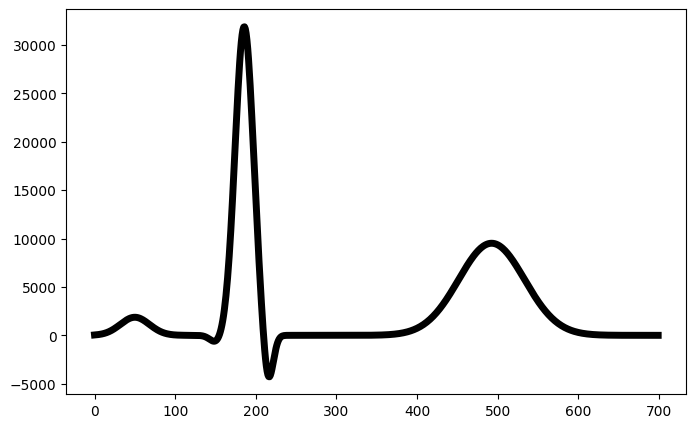

In [4]:

# Create the ECG cycle signal
wave = np.array([gaussian_function(xs, *gaussian_params[i:i+3]) for i in range(0, len(gaussian_params), 3)])
one_sig = np.sum(wave, axis=0)

# Plot the ECG cycle signal
plt.figure(figsize= (8, 5))
plt.plot(one_sig, color = "black", linewidth = 5)
plt.show()


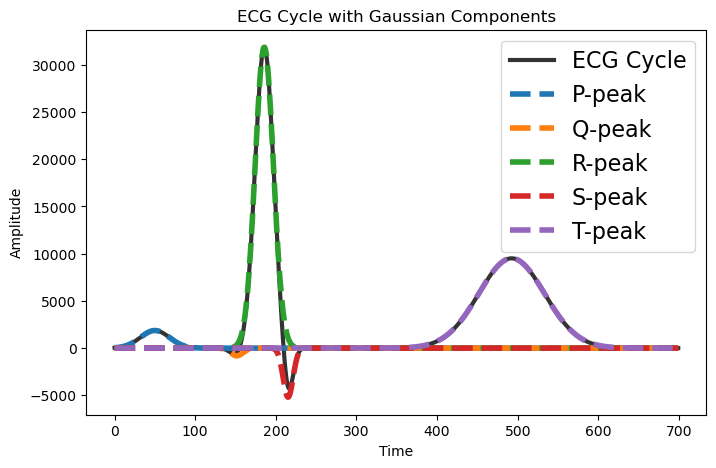

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Function to compute the Gaussian
def gaussian_function(x, mean, amplitude, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

# Labels for the peaks
peak_labels = ['P-peak', 'Q-peak', 'R-peak', 'S-peak', 'T-peak']

# Plot the ECG cycle signal
plt.figure(figsize=(8, 5))
plt.plot(xs, one_sig, color="black", label='ECG Cycle', linewidth=3, alpha=0.8)

# Overlay each Gaussian component
for i in range(0, len(gaussian_params), 3):
    mean, amplitude, stddev = gaussian_params[i:i+3]
    gaussian = gaussian_function(xs, mean, amplitude, stddev)
    plt.plot(xs, gaussian, linestyle='--', linewidth=4, label=peak_labels[i//3])

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('ECG Cycle with Gaussian Components')
plt.legend(fontsize=16)  # Increase the font size of the legend
plt.show()

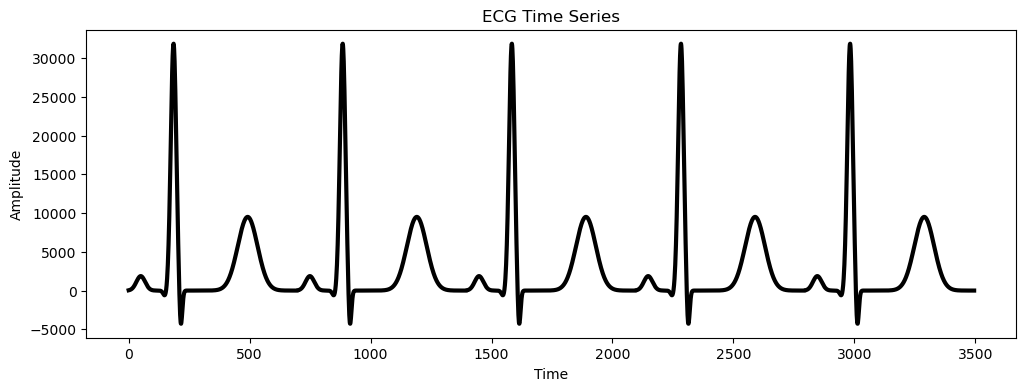

In [55]:
# Number of cycles to concatenate
num_cycles = 5

# Concatenate multiple cycles to create a continuous ECG time series
ecg_time_series = np.tile(one_sig, num_cycles)

# Create a time axis for the ECG time series
time = np.linspace(0, num_cycles * xs[-1], len(ecg_time_series))

# Plot the ECG time series
plt.figure(figsize=(12, 4))
plt.plot(time, ecg_time_series, color="black", linewidth=3)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('ECG Time Series')
plt.show()

#### Single ECG Cycles - Manipulating Presence of Peaks

In [78]:
################## 
#NO R
################## 
# #Gaussian Params 
# gaussian_params = np.array([ 5.00000000e+01,  1.86660441e+03,  1.79841848e+01,  
#                                  1.51461650e+02,  -8.16814518e+02,  7.71994180e+00,  
#                                  0.1,  0.1, 0.1,  
#                                  2.15193654e+02, -5.20392350e+03,  6.11511696e+00,
#                                     4.92442009e+02,  9.51070840e+03,  4.08261600e+01])

# # Create the ECG cycle signal
# noR_waveforms = np.array([gaussian_function(xs, *gaussian_params[i:i+3]) for i in range(0, len(gaussian_params), 3)])
# noR_one_sig = np.sum(noR_waveforms, axis=0)

# # Plot the ECG cycle signal
# plt.figure(figsize=(6, 3))
# plt.plot(noR_one_sig)
# plt.show()


################## 
#NO P or T
################## 
# #Real / Original Gaussian Params 
# gaussian_params = np.array([ 0, 0.001, 0.001, 
#                                  1.51461650e+02, -8.16814518e+02, 7.71994180e+00, 
#                                  1.85637028e+02, 3.18867419e+04, 1.13499461e+01,
#                                  2.15193654e+02, -5.20392350e+03,6.11511696e+00,
#                                 0, 0.001, 0.001])

# # Create the ECG cycle signal 
# QRSonly_waveforms = np.array([gaussian_function(xs, *gaussian_params[i:i+3]) for i in range(0, len(gaussian_params), 3)])
# QRSonly_one_sig = np.sum(QRSonly_waveforms, axis=0)

# # Plot the ECG cycle signal
# plt.figure(figsize=(6, 3))
# plt.plot(QRSonly_one_sig)
# plt.show()


################## 
#R only
################## 

# #Real / Original Gaussian Params 
# gaussian_params = np.array([ 0, 0.001, 0.001, 
#                                 0, 0.001, 0.001, 
#                                  1.85637028e+02, 3.18867419e+04, 1.13499461e+01,
#                                 0, 0.001, 0.001, 
#                                 0, 0.001, 0.001])

# # Create the ECG cycle signal 
# Ronly_waveforms = np.array([gaussian_function(xs, *gaussian_params[i:i+3]) for i in range(0, len(gaussian_params), 3)])
# Ronly_one_sig = np.sum(Ronly_waveforms, axis=0)


# # Plot the ECG cycle signal
# plt.figure(figsize=(6, 3))
# plt.plot(Ronly_one_sig)
# plt.show()



# ################## 
# #Q and S only
# ################## 
# #Real / Original Gaussian Params 
# gaussian_params = np.array([ 0, 0.001, 0.001,  
#                                  1.51461650e+02, -8.16814518e+02, 7.71994180e+00, 
#                                  0, 0.001, 0.001, 
#                                  2.15193654e+02, -5.20392350e+03,6.11511696e+00,
#                                 0, 0.001, 0.001])



# # Create the ECG cycle signal 
# QSonly_waveforms = np.array([gaussian_function(xs, *gaussian_params[i:i+3]) for i in range(0, len(gaussian_params), 3)])
# QSonly_one_sig = np.sum(QSonly_waveforms, axis=0)

# # Plot the ECG cycle signal
# plt.figure(figsize=(6, 3))
# plt.plot(QSonly_one_sig)
# plt.show()

# Simulating ECG Timeseries

* Generate the ECG signal.
* Normalize the signal to the range [-1, 1].
* Add Gaussian noise at different levels.
* Save each noisy signal with a name reflecting the noise level.
* Plot a specific window for each noisy signal.

In [22]:
#Gaussian Params 
gaussian_params = np.array([ 5.00000000e+01,  1.86660441e+03,  1.79841848e+01,  
                                 1.51461650e+02,  -8.16814518e+02,  7.71994180e+00,  
                                 1.85637028e+02,  3.18867419e+04, 1.13499461e+01,  
                                 2.15193654e+02, -5.20392350e+03,  6.11511696e+00,
                                 4.92442009e+02,  9.51070840e+03,  4.08261600e+01])

gaussian_params

array([ 5.00000000e+01,  1.86660441e+03,  1.79841848e+01,  1.51461650e+02,
       -8.16814518e+02,  7.71994180e+00,  1.85637028e+02,  3.18867419e+04,
        1.13499461e+01,  2.15193654e+02, -5.20392350e+03,  6.11511696e+00,
        4.92442009e+02,  9.51070840e+03,  4.08261600e+01])

In [93]:
# Provided values
under30_params = np.array([
    511640.627, 2265.44, 13.07,
    511749.4961, -3925.27, 14.87,
    511781.4439, 36108.94, 9.55,
    511815.2556, -7971.01, 12.84,
    512029.0064, 9094.58, 34.58
])

# Provided Gaussian parameters for over 60 (bootstrapped)
over60_params = np.array([
    462271.1438, 2666.013737, 15.94241757,
    462397.1736, -3590.407788, 11.73794099,
    462435.4382, 39278.88598, 9.854689335,
    462482.9584, -6258.86622, 23.01140547,
    462719.996, 8487.084723, 33.57507346
])

# # Print the results
# print("Gaussian Under 30 Params:", under30_params)
# print("Gaussian Over 60 Params:", over60_params)


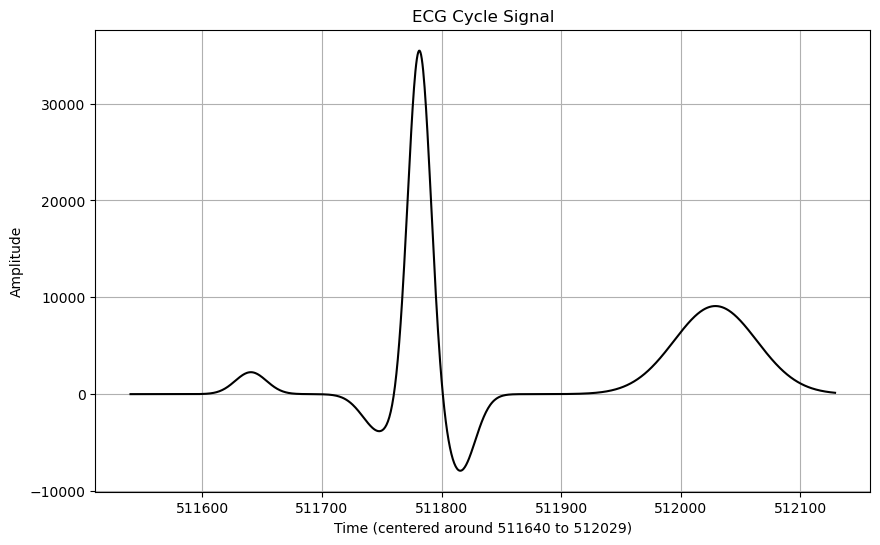

In [94]:
# Generate x values centered around the original center values
x_min = 511640 - 100  # Adjust as needed to center the plot
x_max = 512029 + 100  # Adjust as needed to center the plot
xs = np.linspace(x_min, x_max, 1000)

# Create the ECG cycle signal
wave = np.array([gaussian_function(xs, *under30_params[i:i+3]) for i in range(0, len(under30_params), 3)])
one_sig = np.sum(wave, axis=0)

# Plot the ECG cycle signal
plt.figure(figsize=(10, 6))
plt.plot(xs, one_sig, color="black")
plt.title("ECG Cycle Signal")
plt.xlabel("Time (centered around 511640 to 512029)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [95]:
#shift x center values 

# Provided values
shifted_under30_params = np.array([
    150, 2265.44, 13.07,
    262.95,  -3925.27, 14.87,
    295.65, 36108.94, 9.55,
    329.13, -7971.01, 12.84,
    556.53, 9094.58, 34.58
])

# Provided Gaussian parameters for over 60 (bootstrapped)
shifted_over60_params = np.array([
    150, 3047.29, 16.09,
    266.66, -4383.78, 16.33,
    303.93, 39758.48, 10.51,
    350.03, -7899.24, 20.96,
    580.27, 9714.59, 34.43
])

# # Print the results
# print("Gaussian Under 30 Params:", under30_params)
# print("Gaussian Over 60 Params:", over60_params)


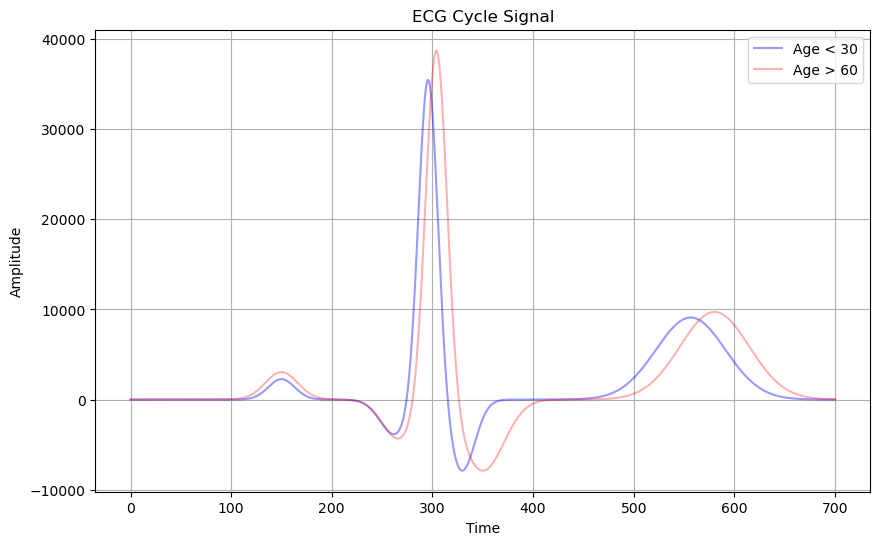

In [97]:
# Generate x values centered around the original center values
x_min = 0  # Adjust as needed to center the plot
x_max = 700  # Adjust as needed to center the plot
xs = np.linspace(x_min, x_max, 700)

# Create the ECG cycle signal
wave_30 = np.array([gaussian_function(xs, *shifted_under30_params[i:i+3]) for i in range(0, len(shifted_under30_params), 3)])
one_sig_30 = np.sum(wave_30, axis=0)

wave_60 = np.array([gaussian_function(xs, *shifted_over60_params[i:i+3]) for i in range(0, len(shifted_over60_params), 3)])
one_sig_60 = np.sum(wave_60, axis=0)


# Plot the ECG cycle signal
plt.figure(figsize=(10, 6))
plt.plot(xs, one_sig_30, color="blue", alpha=0.4, label="Age < 30")
plt.plot(xs, one_sig_60, color="red", alpha=0.3, label="Age > 60")
plt.title("ECG Cycle Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()  
plt.grid(True)
plt.show()

## Varying noise levels

In [ ]:
#Gaussian Params 
gaussian_params = np.array([ 5.00000000e+01,  1.86660441e+03,  1.79841848e+01,  
                                 1.51461650e+02,  -8.16814518e+02,  7.71994180e+00,  
                                 1.85637028e+02,  3.18867419e+04, 1.13499461e+01,  
                                 2.15193654e+02, -5.20392350e+03,  6.11511696e+00,
                                 4.92442009e+02,  9.51070840e+03,  4.08261600e+01])

sig = generate_signal(time_range = time_range, xs=xs, min_spike_interval=min_spike_interval, gaussian_params=gaussian_params)

# Normalize the signal to the range [-1, 1]
normalized_sig = normalize_signal_to_minus_one_to_one(sig)



# Define the noise levels for different simulations
#a lower noise value corresponds to a lower standard deviation of the Gaussian noise, which means less noise.
noise_levels = [0.01, 0.05, 0.1, 0.2]  # Different noise levels for comparison

# Define the directory to save the files
directory = "simulated_ecg_timeseries"

# Loop over the noise levels to create and save noisy signals
for noise_level in noise_levels:
    # Add Gaussian noise to the normalized ECG signal
    noisy_sig = add_gaussian_noise(normalized_sig, noise_level)
    
    # Extract the subset of the time range and signal for plotting
    time_range_cropped = time_range[CROP_MIN:CROP_MAX]
    normalized_sig_cropped = normalized_sig[CROP_MIN:CROP_MAX]
    noisy_sig_cropped = noisy_sig[CROP_MIN:CROP_MAX]
    
    # Save the noisy signal to a file
    file_name = f"{directory}/{noise_level}_ecgsim.npy"
    np.save(file_name, noisy_sig)
    print(f"Saved noisy signal with noise level {noise_level} to {file_name}")
    
    # Plot the cropped signals
    plt.figure(figsize=(15, 5))
    plt.plot(time_range_cropped, normalized_sig_cropped, label='Normalized Signal', alpha=1)
    plt.plot(time_range_cropped, noisy_sig_cropped, label=f'Noisy Signal (Noise Level: {noise_level})', alpha=0.5)
    plt.legend()
    plt.title(f"ECG Signal with Gaussian Noise (Cropped, Noise Level: {noise_level})")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

### Changing R Amplitude

In [8]:
#### Changing R height

# #Real / Original Gaussian Params 
# gaussian_params_real = np.array([ 5.00000000e+01,  1.86660441e+03,  1.79841848e+01,  
#                                  1.51461650e+02,  -8.16814518e+02,  7.71994180e+00,  
#                                  1.85637028e+02,  3.18867419e+04, 1.13499461e+01,  
#                                  2.15193654e+02, -5.20392350e+03,  6.11511696e+00,
#                                     4.92442009e+02,  9.51070840e+03,  4.08261600e+01])

#Increased R amplitude
gaussian_params_tall = np.array([ 5.00000000e+01,  1.86660441e+03,  1.79841848e+01,  
                                1.51461650e+02, -8.16814518e+02,  7.71994180e+00,  
                                1.85637028e+02,  7.18867419e+04, 1.13499461e+01,  
                                2.15193654e+02, -5.20392350e+03,  6.11511696e+00,
                                   4.92442009e+02,  9.51070840e+03,  4.08261600e+01])

#Decreased R amplitude 
gaussian_params_short = np.array([ 5.00000000e+01,  1.86660441e+03,  1.79841848e+01, 
                                   1.51461650e+02, -8.16814518e+02,  7.71994180e+00, 
                                     1.85637028e+02,  4.18867419e+04, 1.13499461e+01,  
                                     2.15193654e+02, -5.20392350e+03,  6.11511696e+00,
                                    4.92442009e+02,  9.51070840e+03,  4.08261600e+01])


In [16]:

# Create the ECG cycle signal 

##########
#########

#### High Amplitude R
waveforms = np.array([gaussian_function(xs, *gaussian_params_tall[i:i+3]) for i in range(0, len(gaussian_params_tall), 3)])
tall_cycle_sig = np.sum(waveforms, axis=0)

##########
#########
waveforms = np.array([gaussian_function(xs, *gaussian_params_short[i:i+3]) for i in range(0, len(gaussian_params_short), 3)])
short_cycle_sig = np.sum(waveforms, axis=0)

##########
#########

# # Calculate the Power Spectral Density (PSD) using Welch's method
# #Simple Welch Input
# fs = 1000  # Sampling frequency (Hz)
# nperseg = 512  # Example window length
# noverlap = 256  # Example overlap percentage

# # Plot the ECG cycle signal
# plt.figure(figsize=(6, 3))
# plt.plot(tall_cycle_sig, color = "#628266")
# plt.plot(short_cycle_sig, color = "#FBB753")
# # plt.plot(real_cycle_sig)
# plt.show()



In [17]:
##MAKE REPEATED SIGNAL 
#this is called from below
tall_sig = generate_signal(time_range = time_range, xs=xs, min_spike_interval=min_spike_interval, gaussian_params=gaussian_params_tall)
# plt.plot(tall_sig)

short_sig = generate_signal(time_range = time_range, xs=xs, min_spike_interval=min_spike_interval, gaussian_params=gaussian_params_short)
# plt.plot(short_sig)

# Plot the Power Spectral Density (PSD) in log-log space for both signals

fs = 1000  # Sampling frequency (Hz)
nperseg = 512  # Example window length
noverlap = 256  # Example overlap percentage

# Calculate the Power Spectral Density (PSD) using Welch's method
f_short, Pxx_short = welch(short_sig, fs=1000, nperseg=nperseg, noverlap=noverlap)
f_tall, Pxx_tall = welch(tall_sig, fs=1000, nperseg=nperseg, noverlap=noverlap)

# plt.figure(figsize=(5, 2.5))
# plt.loglog(f_short, Pxx_short, label='Short R', color = "#FBB753")
# plt.loglog(f_tall, Pxx_tall, label='Tall R', color = "#628266")
# plt.title('PSD Simulated Cycles (Welch\'s)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power/Frequency (dB/Hz)')
# plt.legend()
# plt.show()

### Changing R Width 

In [18]:
# #Real / Original Gaussian Params 

#Gaussian Params 
gaussian_params = np.array([ 5.00000000e+01,  1.86660441e+03,  1.79841848e+01,  
                                 1.51461650e+02,  -8.16814518e+02,  7.71994180e+00,  
                                 1.85637028e+02,  3.18867419e+04, 1.13499461e+01,  
                                 2.15193654e+02, -5.20392350e+03,  6.11511696e+00,
                                 4.92442009e+02,  9.51070840e+03,  4.08261600e+01])

# Create the ECG cycle signal
wave = np.array([gaussian_function(xs, *gaussian_params[i:i+3]) for i in range(0, len(gaussian_params), 3)])
cycle_sig = np.sum(wave, axis=0)

# # Plot the ECG cycle signal
# plt.figure(figsize=(6, 3))
# plt.plot(cycle_sig)
# plt.show()



In [19]:
# Define parameters for the wide peak
peak_index = 2
desired_width_wide = 12

# Extract the parameters for the specified peak
peak_params = gaussian_params[peak_index*3 : (peak_index+1)*3]
center, height, width = peak_params

# Determine the width change
width_change = desired_width_wide - width

# Determine the adjustment factor for neighboring peaks
adjustment_factor = width_change / width

# Update the center values of neighboring peaks (Q and S)
if peak_index > 0:
    gaussian_params[(peak_index-1)*3] -= 5
if peak_index < (len(gaussian_params) // 3) - 1:
    gaussian_params[(peak_index+1)*3] += 5

# Update the width of the specified peak
gaussian_params[peak_index*3 + 2] = desired_width_wide

# Print the updated parameters and the new width
print("\nUpdated parameters:")
print(gaussian_params)
print("\nNew width of the R peak:", desired_width_wide)

# Create the ECG cycle signal
wide_wave = np.array([gaussian_function(xs, *gaussian_params[i:i+3]) for i in range(0, len(gaussian_params), 3)])
wide_cycle_sig = np.sum(wide_wave, axis=0)


##MAKE REPEATED SIGNAL 
#this is called from below
wide_sig = generate_signal(time_range = time_range, xs=xs, min_spike_interval=min_spike_interval, gaussian_params=gaussian_params)
# plt.plot(wide_sig, color = "#636ACC")



Updated parameters:
[ 5.00000000e+01  1.86660441e+03  1.79841848e+01  1.46461650e+02
 -8.16814518e+02  7.71994180e+00  1.85637028e+02  3.18867419e+04
  1.20000000e+01  2.20193654e+02 -5.20392350e+03  6.11511696e+00
  4.92442009e+02  9.51070840e+03  4.08261600e+01]

New width of the R peak: 12


In [20]:
# Define parameters for the narrow peak
peak_index = 2
desired_width = 8

# Extract the parameters for the specified peak
peak_params = gaussian_params[peak_index*3 : (peak_index+1)*3]
center, height, width = peak_params

# Determine the width change
width_change = desired_width - width

# Determine the adjustment factor for neighboring peaks
adjustment_factor = width_change / width

# Update the center values of neighboring peaks (Q and S)
if peak_index > 0:
    gaussian_params[(peak_index-1)*3] -= -8
if peak_index < (len(gaussian_params) // 3) - 1:
    gaussian_params[(peak_index+1)*3] += -8

# Update the width of the specified peak
gaussian_params[peak_index*3 + 2] = desired_width

# Print the updated parameters and the new width
print("\nUpdated parameters:")
print(gaussian_params)
print("\nNew width of the R peak:", desired_width)

# Create the ECG cycle signal
narr_wave = np.array([gaussian_function(xs, *gaussian_params[i:i+3]) for i in range(0, len(gaussian_params), 3)])
narr_cycle_sig = np.sum(narr_wave, axis=0)

# plt.plot(narr_cycle_sig)

##MAKE REPEATED SIGNAL 
#this is called from below
narr_sig = generate_signal(time_range=time_range, xs=xs, min_spike_interval=min_spike_interval, gaussian_params=gaussian_params)
# plt.plot(narr_sig, color = "#63cc91")



Updated parameters:
[ 5.00000000e+01  1.86660441e+03  1.79841848e+01  1.54461650e+02
 -8.16814518e+02  7.71994180e+00  1.85637028e+02  3.18867419e+04
  8.00000000e+00  2.12193654e+02 -5.20392350e+03  6.11511696e+00
  4.92442009e+02  9.51070840e+03  4.08261600e+01]

New width of the R peak: 8


In [21]:
# # Plot the narrow and wide R ECG cycle signal
# plt.figure(figsize=(6, 3))
# plt.plot(wide_cycle_sig, color = "#636ACC" )
# plt.plot(narr_cycle_sig, color = "#63cc91")
# plt.show()

In [22]:
# Power Spectral Density (PSD) in log-log space for both signals
fs = 1000  # Sampling frequency (Hz)
nperseg = 512  # Example window length
noverlap = 256  # Example overlap percentage

# Calculate the Power Spectral Density (PSD) using Welch's method
f_narr, Pxx_narr = welch(narr_sig, fs=1000, nperseg=nperseg, noverlap=noverlap)
f_wide, Pxx_wide = welch(wide_sig, fs=1000, nperseg=nperseg, noverlap=noverlap)

# plt.figure(figsize=(5, 2.5))
# plt.loglog(f_narr, Pxx_narr, label='Narrow R (8 STD)', color = "#63cc91")
# plt.loglog(f_wide, Pxx_wide, label='Wide R (12 STD)', color = "#636ACC" )
# plt.title('PSD Simulated Cycles (Welch\'s)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power/Frequency (dB/Hz)')
# plt.legend()
# plt.show()


# Simulating Poisson Signal

In [7]:
poisson_process, poisson_sig = generate_poisson_signal(time_range = time_range, rate_parameter = rate_parameter, min_spike_interval = min_spike_interval, seed = seed, xs = xs, gaussian_params = gaussian_params)

# #Plot the poisson ecg signal
# plt.plot(poisson_sig[CROP_MIN:CROP_MAX], color = "#f47a00")
# plt.xlabel('Time (ms)')
# plt.ylabel('ECG Signal')
# plt.title('ECG Simulation (Poisson; 60 s)')
# plt.show()

# Print the spike count
poisson_count = np.sum(poisson_process)
print("Poisson cycle count:", poisson_count)


f_poisson, Pxx_poisson = welch(poisson_sig, fs=1000, nperseg=nperseg, noverlap=noverlap)

# # Plot the Power Spectral Density (PSD) in log-log space for both signals
# plt.figure(figsize=(6, 4))
# plt.loglog(f_poisson, Pxx_poisson, label = 'ECG Poisson', color = "#f47a00")
# plt.title('PSD (Welchs) ECG Simulation (Poisson; 60 s)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power/Frequency (dB/Hz)')
# plt.legend()
# plt.show()


Poisson cycle count: 63.0


In [8]:
l_time_range = np.arange(0, 10,000,000)

l_poisson_process, l_poisson_sig = generate_poisson_signal(time_range = l_time_range, rate_parameter = rate_parameter, min_spike_interval = min_spike_interval, seed = seed, xs = xs, gaussian_params = gaussian_params)

# Print the spike count
poisson_count = np.sum(l_poisson_process)
print("Poisson cycle count:", poisson_count)

l_f_poisson, l_Pxx_poisson = welch(poisson_sig, fs=1000, nperseg=nperseg, noverlap=noverlap)

Poisson cycle count: 9988.0


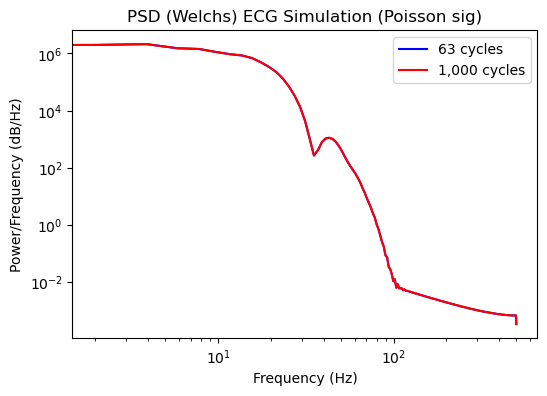

In [13]:
# Plot the Power Spectral Density (PSD) in log-log space for both signals
plt.figure(figsize=(6, 4))
plt.loglog(f_poisson, Pxx_poisson, label = '63 cycles', color = "blue")
plt.loglog(l_f_poisson, l_Pxx_poisson, label = '1,000 cycles', color = "red")

plt.title('PSD (Welchs) ECG Simulation (Poisson sig)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.show()


### HRV metrics

In [19]:
# #HRV Metrics 

# # Assuming ecg_clean is your preprocessed ECG signal
# ecg_clean = nk.ecg_clean(poisson_sig, sampling_rate=1000)

# # Detect R-peaks
# _, rpeaks_dict = nk.ecg_peaks(ecg_clean, sampling_rate=1000)

# # Extract the array of R-peaks
# rpeaks = rpeaks_dict['ECG_R_Peaks']

# # Flatten the array to make it one-dimensional
# rpeaks_flat = rpeaks.flatten()

# # Calculate RR intervals
# rr_intervals = np.diff(rpeaks_flat)

# # Time-domain HRV measures
# mean_rr_interval = np.mean(rr_intervals)

# # SDNN (Standard Deviation of NN Intervals): A measure of overall variability in the heart rate.
# sdnn = np.std(rr_intervals)

# # RMSSD (Root Mean Square of Successive Differences): Reflects short-term variability and parasympathetic nervous system activity.
# rmssd = np.sqrt(np.mean(np.diff(rr_intervals)**2))

# # NN50: Number of pairs of successive RR intervals differing by more than 50 ms.
# nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 50)

# # Display HRV measures
# print("Mean RR Interval:", mean_rr_interval, "ms")

# #SDNN provides a measure of the overall variability in the heart rate, reflecting the combined 
# #influences of both the sympathetic and parasympathetic nervous systems. A higher SDNN value 
# #indicates greater variability in the heart rate, suggesting a more adaptable autonomic nervous system.
# print("SDNN:", sdnn, "ms (Standard Deviation of NN Intervals)")

# print("RMSSD:", rmssd, "ms (Root Mean Square of Successive Differences)")
# print("NN50:", nn50, " (Number of pairs of successive RR intervals differing by more than 50 ms)")


# Simulating Rhythmic Signal

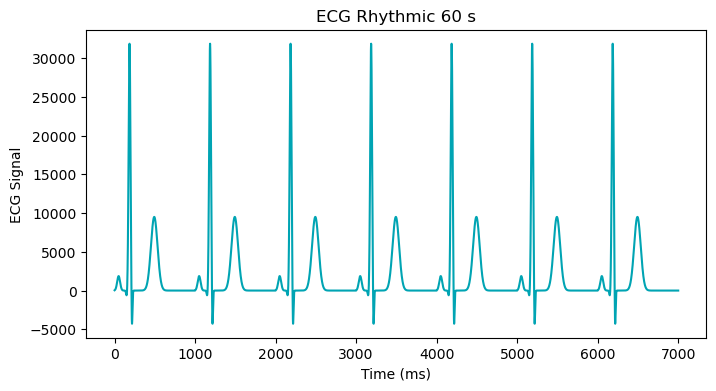

Rhythmic cycle count: [1. 0. 0. ... 0. 0. 0.]


In [29]:
#generate sig
rhythmic_process, rhythmic_sig = generate_rhythmic_signal(time_range = time_range, xs=xs, min_spike_interval=min_spike_interval, gaussian_params=gaussian_params)

CROP_MIN = 0
CROP_MAX = 7000

plt.figure(figsize=(8, 4))
# Plot the signal
plt.plot(rhythmic_sig[CROP_MIN:CROP_MAX], color = "#00a4b3")
plt.xlabel('Time (ms)')
plt.ylabel('ECG Signal')
plt.title('ECG Rhythmic 60 s')
plt.show()

# Print the spike count
rhythmic_count = np.sum(rhythmic_process)
print("Rhythmic cycle count:", rhythmic_process)


# #Plot the rhythmic ecg signal
# plt.plot(rhythmic_sig, color = "green")
# plt.xlabel('Time (ms)')
# plt.ylabel('ECG Signal')
# plt.title('ECG Simulation (Rhythmic; 60 s)')
# plt.show()

# # Print the spike count
# rhythmic_count = np.sum(rhythmic_process)
# print("Rhythmic cycle count:", rhythmic_count)

# # Print the spike count
# poisson_count = np.sum(poisson_process)
# print("Poisson cycle count:", poisson_count)


# f_rhythmic, Pxx_rhythmic = welch(rhythmic_sig, fs=1000, nperseg=nperseg, noverlap=noverlap)

# # Plot the Power Spectral Density (PSD) in log-log space for both signals
# plt.figure(figsize=(6, 3))
# plt.loglog(f_poisson, Pxx_poisson, label = 'High HRV', color = "#f47a00")
# plt.loglog(f_rhythmic, Pxx_rhythmic, label = 'Low HRV ', color = "#00a4b3")

# plt.title('PSD (Welchs) ECG Simulation (Rhythmic; 60 s)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power/Frequency (dB/Hz)')
# plt.legend()
# plt.show()





### Fast vs. Slow Rhythmic Signals

In [21]:
# Rhythmic process 

## Fast 
# Set the time interval between spikes (rhythmic period)
rhythmic_period_fast = 650  # Adjust this value as needed


# Initialize an array to store the rhythmic process
rhythmic_process_fast = np.zeros(len(time_range))

# Generate rhythmic process
last_spike_time = -rhythmic_period_fast
for i in range(len(time_range)):
    if time_range[i] - last_spike_time >= rhythmic_period_fast:
        rhythmic_process_fast[i] = 1
        last_spike_time = time_range[i]

# Print the spike count
cycle_count_fast = np.sum(rhythmic_process_fast)
print("Cycle count:", cycle_count_fast)


Cycle count: 93.0


In [22]:
# Slow signal

# Set the time interval between spikes (rhythmic period)
rhythmic_period_slow = 1000  # Adjust this value as needed

# Initialize an array to store the rhythmic process
rhythmic_process_slow = np.zeros(len(time_range))

# Generate rhythmic process
last_spike_time = -rhythmic_period_slow
for i in range(len(time_range)):
    if time_range[i] - last_spike_time >= rhythmic_period_slow:
        rhythmic_process_slow[i] = 1
        last_spike_time = time_range[i]

# # Plot the rhythmic process
# plt.figure(figsize=(6, 3))
# plt.step(time_range, rhythmic_process_slow, where='post')
# plt.xlabel('Time (ms)')
# plt.ylabel('Event (1) or No Event (0)')
# plt.title('Rhythmic Process with 900 ms Period')
# plt.show()

# Print the spike count
cycle_count_slow = np.sum(rhythmic_process_slow)
print("Cycle count:", cycle_count_slow)

Cycle count: 60.0


In [23]:
#Building our ECG Fast and Slow Simulated Sig 

# Define the length of the signals
signal_length = len(rhythmic_process_fast) # in ms
ecg_cycle_length = len(one_sig) # in ms

# Generate a zero signal
rhythmic_sig_slow = np.zeros(signal_length)
rhythmic_sig_fast = np.zeros(signal_length)

# # Generate a Poisson process 

# Find indices where the Poisson process is equal to 1
trigger_indices_fast = np.where(rhythmic_process_fast == 1)[0]
trigger_indices_slow = np.where(rhythmic_process_slow == 1)[0]

# Insert the ECG cycle at each trigger index
for index in trigger_indices_fast:
    if index + ecg_cycle_length <= signal_length:
        rhythmic_sig_fast[index:index + ecg_cycle_length] = one_sig

for index in trigger_indices_slow:
    if index + ecg_cycle_length <= signal_length:
        rhythmic_sig_slow[index:index + ecg_cycle_length] = one_sig

# plt.plot(rhythmic_sig_slow)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


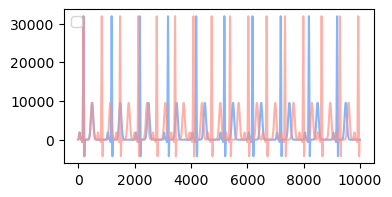

In [24]:
CROP1 = 0
CROP2 = 3000
plt.figure(figsize=(4, 2))
plt.plot(rhythmic_sig_slow[0:10000], color = "#85B5FC", alpha = 1)
plt.plot(rhythmic_sig_fast[0:10000], color = "#fc9185", alpha = 0.7)

# plt.title('PSD (Welch)')
# plt.xlabel('Time')
# plt.ylabel('Amp')
# # plt.grid(True)
plt.legend()
plt.show()


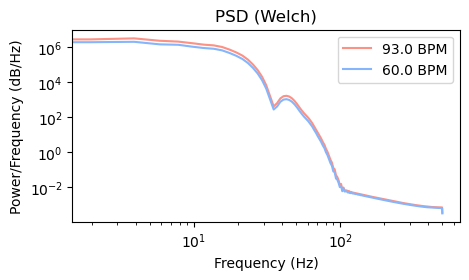

In [25]:
#PSD of Fast vs Slow 

#Wlech

fs = 1000  # Sampling frequency (Hz)
nperseg = 512  # Example window length
noverlap = 256  # Example overlap percentage

# Calculate the Power Spectral Density (PSD) using Welch's method
f_fast, Pxx_fast = welch(rhythmic_sig_fast, fs=1000, nperseg=nperseg, noverlap=noverlap)
f_slow, Pxx_slow = welch(rhythmic_sig_slow, fs=1000, nperseg=nperseg, noverlap=noverlap)


plt.figure(figsize=(5, 2.5))


# Plot the Power Spectral Density (PSD) in log-log space for both signals
plt.loglog(f_fast, Pxx_fast, label=f'{cycle_count_fast} BPM', color = "#fc9185")
plt.loglog(f_slow, Pxx_slow, label=f'{cycle_count_slow} BPM', color = "#85B5FC")
plt.title('PSD (Welch)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
# plt.grid(True)
plt.legend()
plt.show()

# #2-40 only 
# freq_range_mask_sim = (f_fast >= 2) & (f_slow <= 40)

# f_trimmed_fast = f_fast[freq_range_mask_sim]
# Pxx_trimmed_fast = Pxx_fast[freq_range_mask_sim]

# f_trimmed_slow = f_slow[freq_range_mask_sim]
# Pxx_trimmed_slow = Pxx_slow[freq_range_mask_sim]

# plt.figure(figsize=(5, 2.5))

# plt.loglog(f_trimmed_fast, Pxx_trimmed_fast, label=f'{cycle_count_fast} BPM', color = "#fc9185")
# plt.loglog(f_trimmed_slow, Pxx_trimmed_slow, label=f'{cycle_count_slow} BPM', color = "#85B5FC")
# plt.title('PSD (Welch) (2-40Hz)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power/Frequency (dB/Hz)')
# # plt.grid(True)
# plt.legend()
# plt.show()


### HRV Metrics

In [26]:
#HRV Metrics 

# Assuming ecg_clean is your preprocessed ECG signal
ecg_clean = nk.ecg_clean(rhythmic_sig_fast, sampling_rate=1000)

# Detect R-peaks
_, rpeaks_dict = nk.ecg_peaks(ecg_clean, sampling_rate=1000)

# Extract the array of R-peaks
rpeaks = rpeaks_dict['ECG_R_Peaks']

# Flatten the array to make it one-dimensional
rpeaks_flat = rpeaks.flatten()

# Calculate RR intervals
rr_intervals = np.diff(rpeaks_flat)

# Time-domain HRV measures
mean_rr_interval = np.mean(rr_intervals)

# SDNN (Standard Deviation of NN Intervals): A measure of overall variability in the heart rate.
sdnn = np.std(rr_intervals)

# RMSSD (Root Mean Square of Successive Differences): Reflects short-term variability and parasympathetic nervous system activity.
rmssd = np.sqrt(np.mean(np.diff(rr_intervals)**2))

# NN50: Number of pairs of successive RR intervals differing by more than 50 ms.
nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 50)

# Display HRV measures
print("Mean RR Interval:", mean_rr_interval, "ms")

#SDNN provides a measure of the overall variability in the heart rate, reflecting the combined 
#influences of both the sympathetic and parasympathetic nervous systems. A higher SDNN value 
#indicates greater variability in the heart rate, suggesting a more adaptable autonomic nervous system.
print("SDNN:", sdnn, "ms (Standard Deviation of NN Intervals)")

print("RMSSD:", rmssd, "ms (Root Mean Square of Successive Differences)")
print("NN50:", nn50, " (Number of pairs of successive RR intervals differing by more than 50 ms)")


Mean RR Interval: 650.0 ms
SDNN: 0.0 ms (Standard Deviation of NN Intervals)
RMSSD: 0.0 ms (Root Mean Square of Successive Differences)
NN50: 0  (Number of pairs of successive RR intervals differing by more than 50 ms)


# Poisson vs. Rhythmic Comparisons

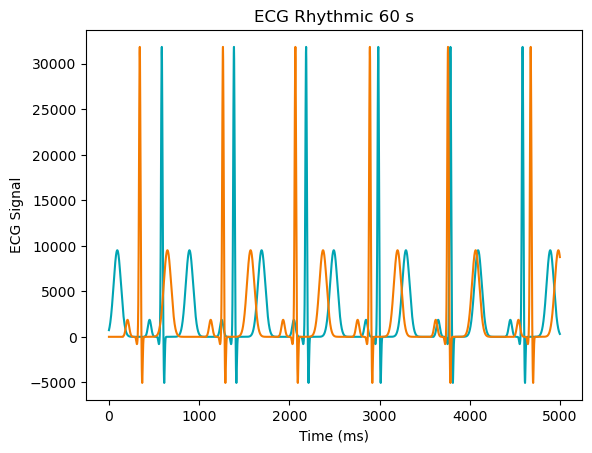

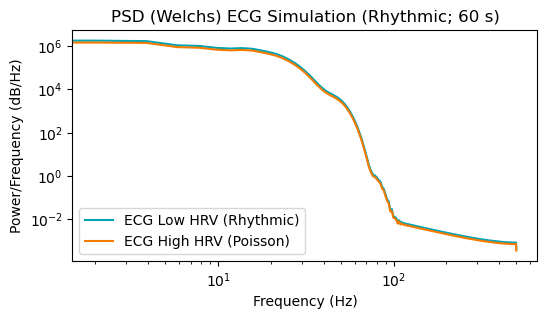

In [27]:
# Plot the signal
plt.plot(rhythmic_sig[CROP_MIN:CROP_MAX], color = "#00a4b3")
plt.plot(poisson_sig[CROP_MIN:CROP_MAX], color = "#f47a00")
plt.xlabel('Time (ms)')
plt.ylabel('ECG Signal')
plt.title('ECG Rhythmic 60 s')
plt.show()

# Plot the Power Spectral Density (PSD) in log-log space for both signals
plt.figure(figsize=(6, 3))
plt.loglog(f_rhythmic, Pxx_rhythmic, label = 'ECG Low HRV (Rhythmic)', color = "#00a4b3")
plt.loglog(f_poisson, Pxx_poisson, label = 'ECG High HRV (Poisson)', color = "#f47a00")

plt.title('PSD (Welchs) ECG Simulation (Rhythmic; 60 s)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.show()


# Aperiodic EEG + ECG Simulations

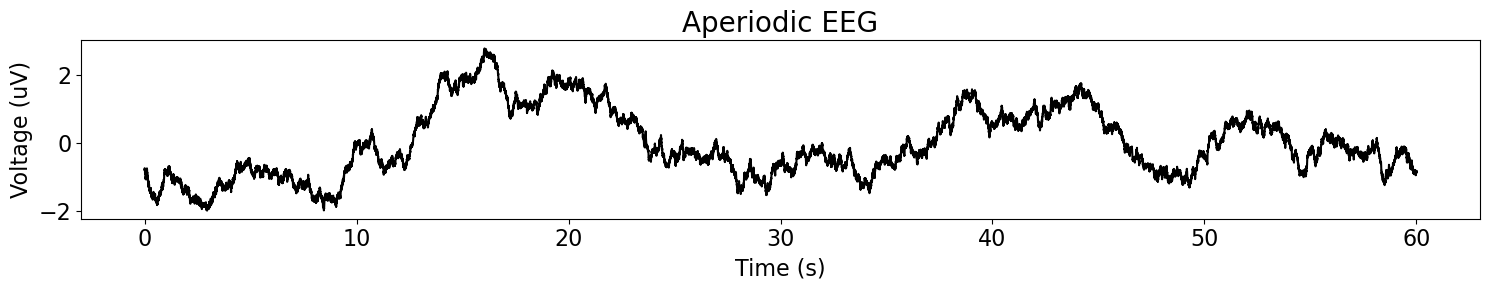

In [34]:

# # Set the random seed, for consistency simulating data
# seed = 5


# Set the random seed, for consistency simulating data
set_random_seed(0)

# Set some general settings, to be used across all simulations
fs = 1000
n_seconds = 60

# Create a times vector for the simulations
times = create_times(n_seconds, fs)

# Set the exponent for brown noise, which is -2
exponent = -2

# Simulate powerlaw activity
br_noise = sim_powerlaw(n_seconds, fs, exponent)


# Plot the simulated data, in the time domain
plot_time_series(times, br_noise, title='Aperiodic EEG')

# Plot the simulated data, in the frequency domain
freqs, psd = compute_spectrum(br_noise, fs)
# plot_power_spectra(freqs, psd)

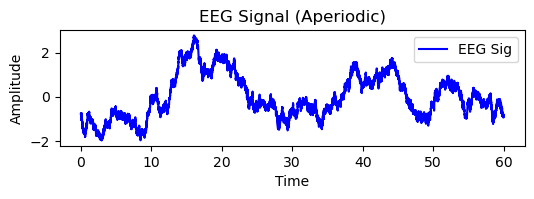

In [35]:
# Plot both signals together
plt.figure(figsize=(6, 1.5))

# Plot EEG signal with cardiac artifacts
plt.plot(times, br_noise, color='blue', label='EEG Sig')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('EEG Signal (Aperiodic)')
# plt.grid(True)
plt.legend()


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 3.91 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -1.5344, 2.1522                                          
                                                                                                  
                                       0 peaks were found:                                        
          

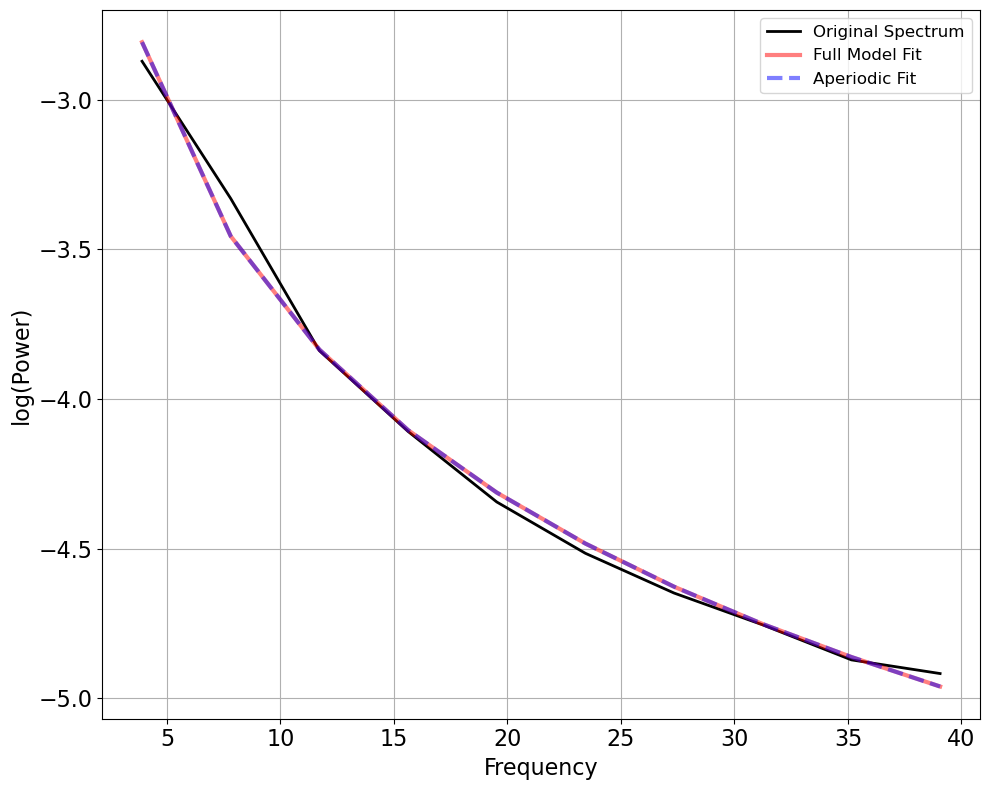

In [38]:
# Set the frequency range to fit the model
freq_range = [2, 40]

# Initialize a FOOOF object
fm = FOOOF(aperiodic_mode='fixed', verbose=False, max_n_peaks=0)


# Fit the model to the data
f_br, Pxx_br = welch(br_noise, fs=1000, nperseg=nperseg, noverlap=noverlap)


# # Report: fit the model, print the resulting parameters, and plot the reconstruction
fm.report(f_br, Pxx_br, freq_range)


## ECG Sig Poisson_ Real Gauss

Poisson cycle count: 63.0


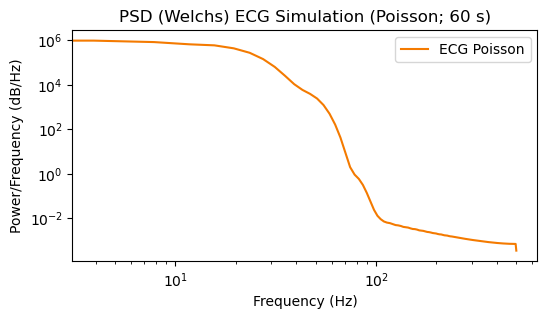

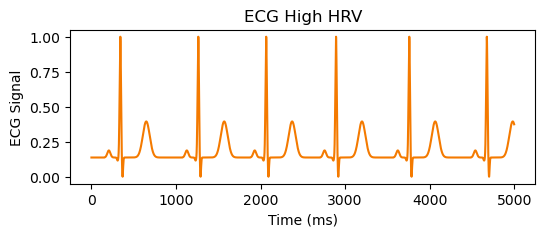

In [39]:
poisson_process, poisson_sig = generate_poisson_signal(time_range = time_range, rate_parameter = rate_parameter, min_spike_interval = min_spike_interval, seed = seed, xs = xs, gaussian_params = gaussian_params)

# Print the spike count
poisson_count = np.sum(poisson_process)
print("Poisson cycle count:", poisson_count)

#PSD WELCH
f_poisson, Pxx_poisson = welch(poisson_sig, fs=1000, nperseg=nperseg, noverlap=noverlap)

# Plot the Power Spectral Density (PSD) in log-log space for both signals
plt.figure(figsize=(6, 3))
plt.loglog(f_poisson, Pxx_poisson, label = 'ECG Poisson', color = "#f47a00")
plt.title('PSD (Welchs) ECG Simulation (Poisson; 60 s)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.show()

## Normalize ECG signal 
poisson_sig_norm = (poisson_sig - np.mean(poisson_sig)) / np.std(poisson_sig)
# Min-Max scaling
ecg_min_max_scaled_poisson = (poisson_sig_norm - np.min(poisson_sig_norm)) / (np.max(poisson_sig_norm) - np.min(poisson_sig_norm))

# Plot the resulting ECG signal
plt.figure(figsize=(6, 2))
plt.plot(ecg_min_max_scaled_poisson[CROP_MIN:CROP_MAX], color = '#f47a00')
plt.xlabel('Time (ms)')
plt.ylabel('ECG Signal')
plt.title('ECG High HRV')
plt.show()


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 3.91 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 3.91 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,

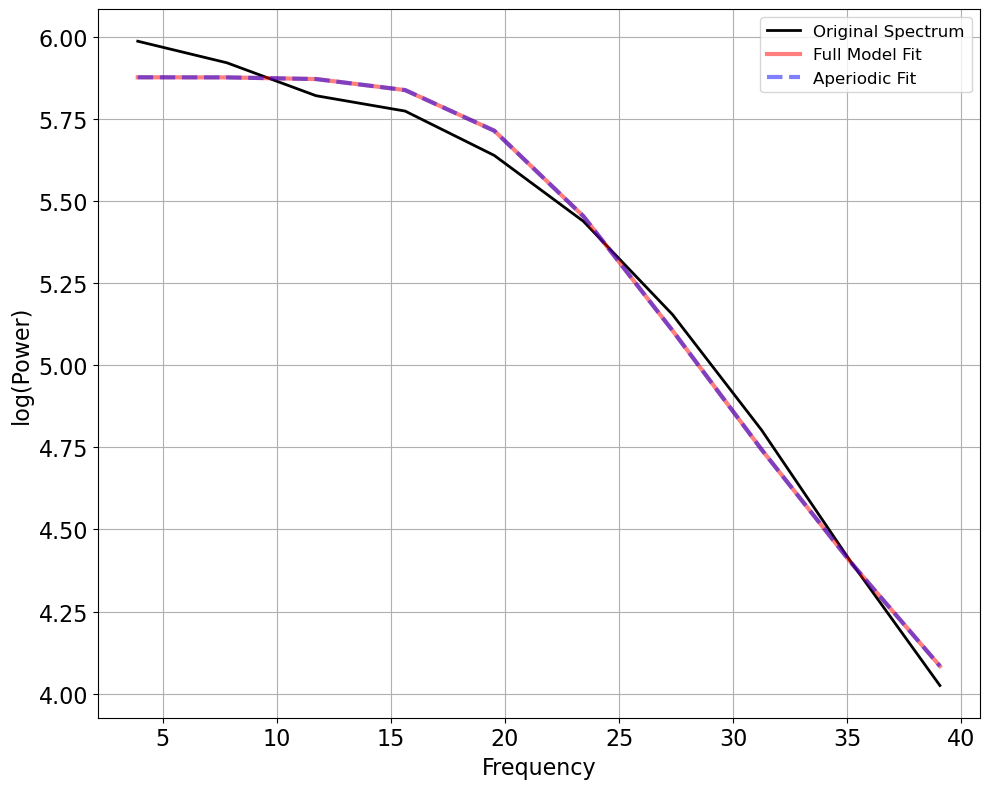

In [59]:
##High HRV: 

# Set the frequency range to fit the model
freq_range = [2, 40]

# Initialize a FOOOF object
fm1 = FOOOF(aperiodic_mode='knee', verbose=True, max_n_peaks=0)


# # Report: fit the model, print the resulting parameters, and plot the reconstruction
fm1.report(f_poisson, Pxx_poisson, freq_range)

# # Plot one of the example power spectra
# plot_spectra(f_poisson, Pxx_poisson, log_powers=True,
#              color='black', label='Original Spectrum')

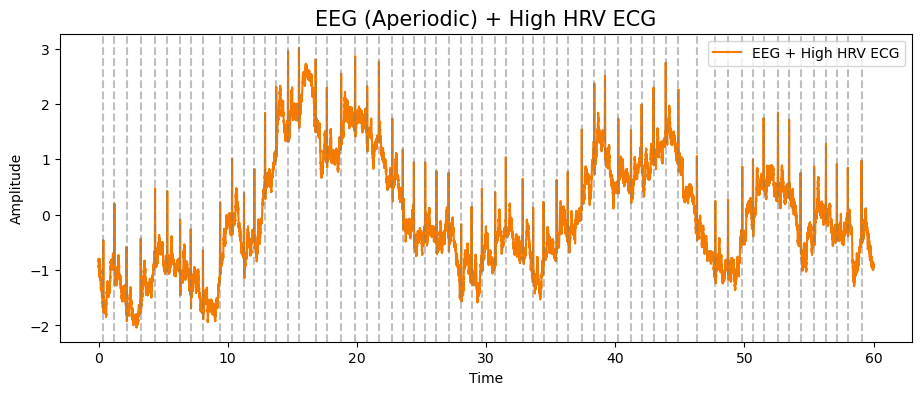

In [41]:
#Combine the EEG and High HRV ECG
# Find the maximum amplitude of br_noise_norm
max_amplitude_br_noise = np.max(np.abs(br_noise))

# Define the scaling factor to make poisson_sig_norm 10% of max_amplitude_br_noise
scaling_factor = (0.4 * max_amplitude_br_noise) / np.max(poisson_sig_norm)

# Scale down the poisson_sig_norm
#The scaling_factor is calculated to scale down the poisson_sig_norm such that its maximum value becomes 10% of the maximum amplitude of br_noise_norm.
scaled_poisson_sig = poisson_sig_norm * scaling_factor

# # Multiply the signals together
# resulting_signal = br_noise * scaled_poisson_sig

# Superimpose the signals by adding them together
resulting_signal_poisson = br_noise + scaled_poisson_sig

# Find the indices of maxima in poisson_sig_norm (cardiac artifact signal)
max_indices = np.where(poisson_sig_norm == np.max(poisson_sig_norm))[0]

# Plot both signals together
plt.figure(figsize=(11, 4))

# Plot EEG signal with cardiac artifacts
plt.plot(times, resulting_signal_poisson, color='#f47a00', label='EEG + High HRV ECG')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('EEG (Aperiodic) + High HRV ECG', fontsize = 15)
plt.legend()
for index in max_indices:
    plt.axvline(x=times[index], color='grey', linestyle='--', alpha = 0.5)
plt.show()


# #PSD 
# #Wlech
# fs = 1000  # Sampling frequency (Hz)
# nperseg = 512  # Example window length
# noverlap = 256  # Example overlap percentage

# # Calculate the Power Spectral Density (PSD) using Welch's method
# #Brown noise aperiodic signal
# f_br, Pxx_br = welch(br_noise, fs=1000, nperseg=nperseg, noverlap=noverlap)

# #Resulting signal after adding EEG to ECG
# f_poisson, Pxx_poisson = welch(resulting_signal_poisson, fs=1000, nperseg=nperseg, noverlap=noverlap)


# plt.figure(figsize=(6, 3))

# # Plot the Power Spectral Density (PSD) in log-log space for both signals
# plt.loglog(f_poisson, Pxx_poisson, label='EEG + High HRV ECG', color='#f47a00' )
# plt.loglog(f_br, Pxx_br, label='EEG Aperiodic',color='blue')

# plt.title('Power Spectral Density (Welchs Method)')
# plt.xlabel('Frequency (Hz)')
# # plt.grid(True)
# plt.ylabel('Power/Frequency (dB/Hz)')
# plt.legend()
# plt.show()



## ECG Sig Rhythmic_Real Gauss

Rhythmic cycle count: [1. 0. 0. ... 0. 0. 0.]


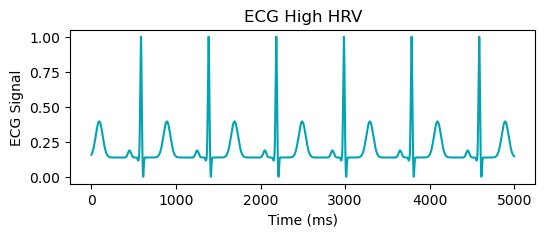

In [42]:
#generate sig
rhythmic_process, rhythmic_sig = generate_rhythmic_signal(time_range = time_range, xs=xs, min_spike_interval=min_spike_interval, gaussian_params=gaussian_params)

# Print the spike count
rhythmic_count = np.sum(rhythmic_process)
print("Rhythmic cycle count:", rhythmic_process)

## Normalize ECG signal 
rhythmic_sig_norm = (rhythmic_sig - np.mean(rhythmic_sig)) / np.std(rhythmic_sig)
# Min-Max scaling
ecg_min_max_scaled_rhythmic = (rhythmic_sig_norm - np.min(rhythmic_sig_norm)) / (np.max(rhythmic_sig_norm) - np.min(rhythmic_sig_norm))

# Plot the resulting ECG signal
plt.figure(figsize=(6, 2))
plt.plot(ecg_min_max_scaled_rhythmic[CROP_MIN:CROP_MAX], color = '#00a4b3')
plt.xlabel('Time (ms)')
plt.ylabel('ECG Signal')
plt.title('ECG High HRV')
plt.show()

#### Plot High and Low HRV


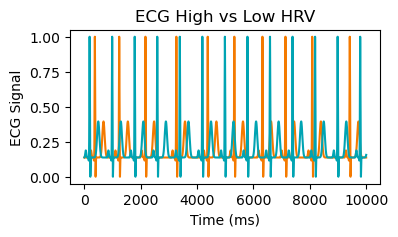

In [43]:
# Plot the resulting ECG signal
plt.figure(figsize=(4, 2))
plt.plot(ecg_min_max_scaled_poisson[0:10000], color = '#f47a00')
plt.plot(ecg_min_max_scaled_rhythmic[0:10000], color = '#00a4b3')

plt.xlabel('Time (ms)')
plt.ylabel('ECG Signal')
plt.title('ECG High vs Low HRV')
plt.show()

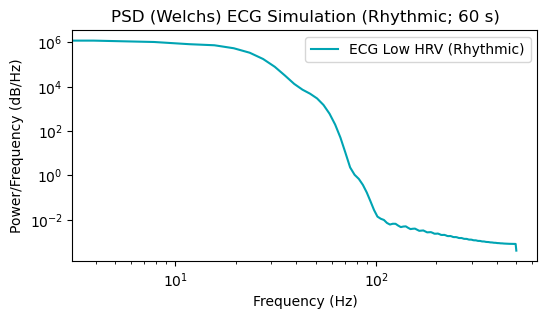

In [44]:
#Welch
f_rhythmic, Pxx_rhythmic = welch(rhythmic_sig, fs=1000, nperseg=nperseg, noverlap=noverlap)

# Plot the Power Spectral Density (PSD) in log-log space for both signals
plt.figure(figsize=(6, 3))
plt.loglog(f_rhythmic, Pxx_rhythmic, label = 'ECG Low HRV (Rhythmic)', color = "#00a4b3")
plt.title('PSD (Welchs) ECG Simulation (Rhythmic; 60 s)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.show()

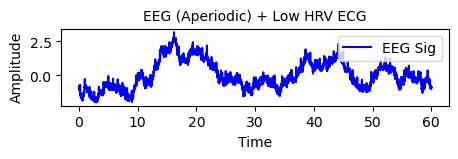

In [45]:
#Put EEG and Low HRV ECG Together

# Find the maximum amplitude of br_noise_norm
max_amplitude_br_noise = np.max(np.abs(br_noise))

# Define the scaling factor to make poisson_sig_norm 10% of max_amplitude_br_noise
scaling_factor = (0.2 * max_amplitude_br_noise) / np.max(rhythmic_sig_norm)

# Scale down the poisson_sig_norm
#The scaling_factor is calculated to scale down the poisson_sig_norm such that its maximum value becomes 10% of the maximum amplitude of br_noise_norm.
scaled_rhythmic_sig = rhythmic_sig_norm * scaling_factor

# # Multiply the signals together
# Superimpose the signals by adding them together
resulting_signal_rhythmic = br_noise + scaled_rhythmic_sig

# Find the indices of maxima in poisson_sig_norm (cardiac artifact signal)
max_indices = np.where(rhythmic_sig_norm == np.max(rhythmic_sig_norm))[0]

plt.figure(figsize=(5, 1))
# Plot EEG signal 
#'#00a4b3'
plt.plot(times, resulting_signal_rhythmic, color='blue', label='EEG Sig')

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('EEG (Aperiodic) + Low HRV ECG', fontsize = 10)
plt.legend()
# for index in max_indices:
#     plt.axvline(x=times[index], color='grey', linestyle='--', alpha = 0.5)

plt.show()

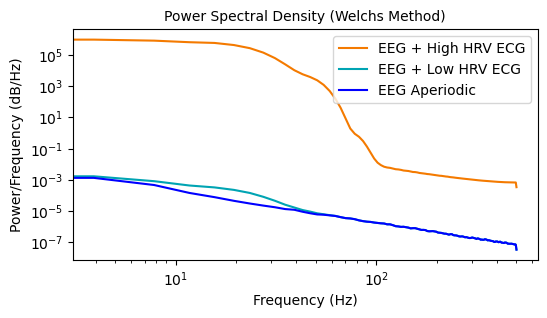

In [46]:
#PSD Wlech

# Calculate the Power Spectral Density (PSD) using Welch's method
f_rhythmic, Pxx_rhythmic = welch(resulting_signal_rhythmic, fs=1000, nperseg=nperseg, noverlap=noverlap)

plt.figure(figsize=(6, 3))

# Plot the Power Spectral Density (PSD) in log-log space for both signals
plt.loglog(f_poisson, Pxx_poisson, label='EEG + High HRV ECG', color='#f47a00' )
plt.loglog(f_rhythmic, Pxx_rhythmic, label='EEG + Low HRV ECG', color = '#00a4b3')
plt.loglog(f_br, Pxx_br, label='EEG Aperiodic', color = 'blue')
plt.title('Power Spectral Density (Welchs Method)', fontsize=10)
plt.xlabel('Frequency (Hz)')
# plt.grid(True)
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.show()



## ECG Sig Rhythmic_R Width


Updated parameters:
[ 5.00000000e+01  1.86660441e+03  1.79841848e+01  1.62461650e+02
 -8.16814518e+02  7.71994180e+00  1.85637028e+02  3.18867419e+04
  8.00000000e+00  2.04193654e+02 -5.20392350e+03  6.11511696e+00
  4.92442009e+02  9.51070840e+03  4.08261600e+01]

New width of the R peak: 8


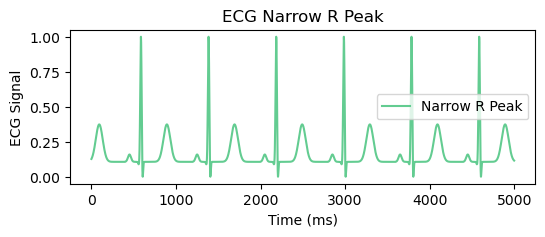

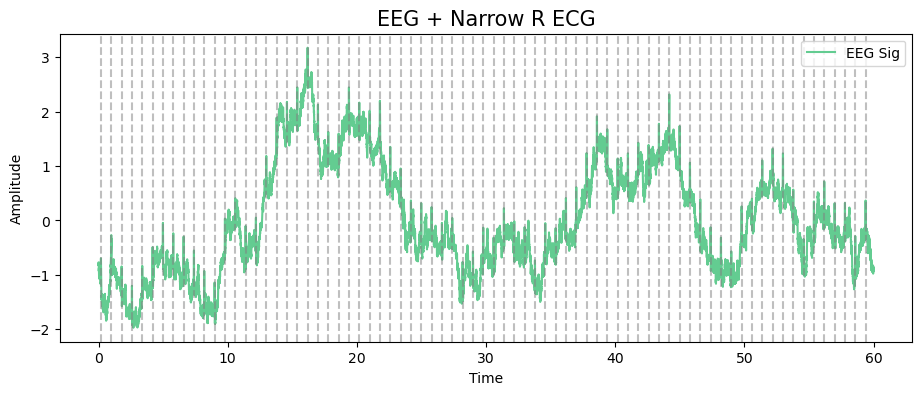

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 3.91 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -0.2414, 9.1877, 2.6671                                      
                                                                                                  
                                       0 peaks were found:                                        
          

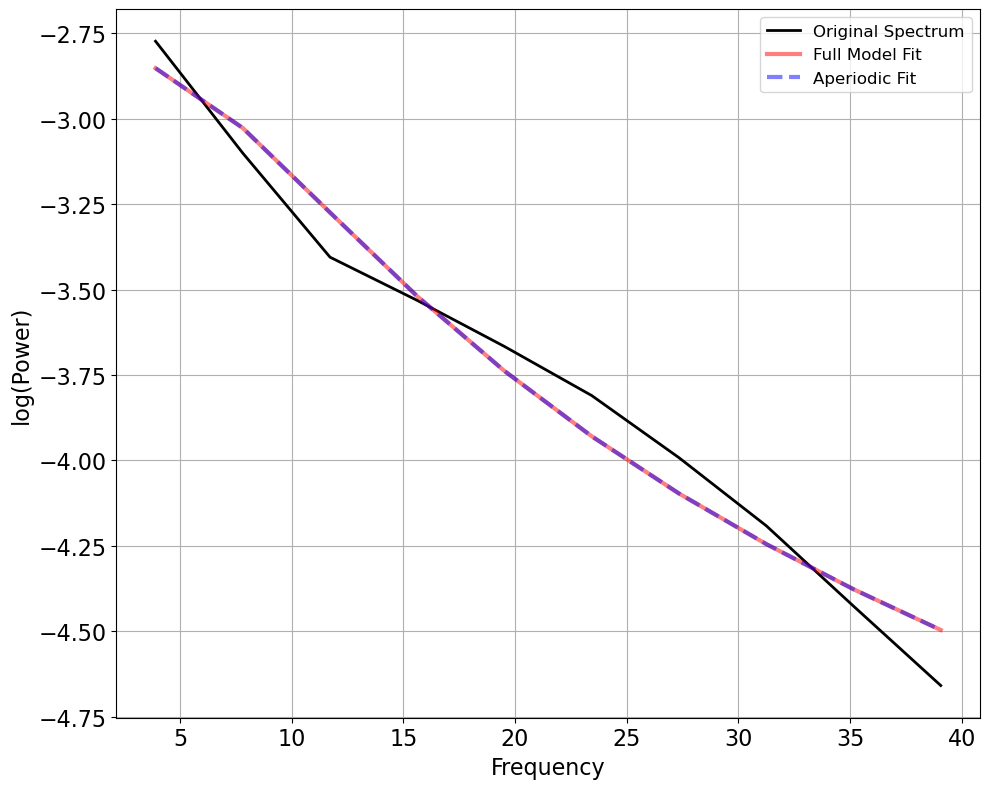

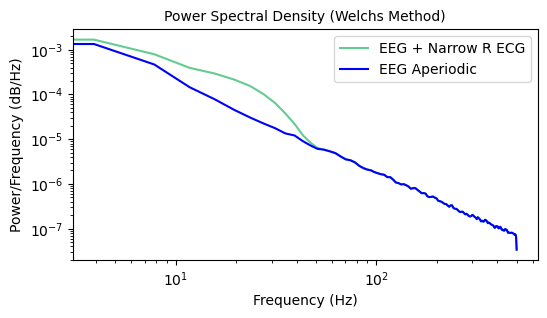

In [47]:
#narrow 
# Define parameters for the narrow peak
peak_index = 2
desired_width_narrow = 8

# Extract the parameters for the specified peak
peak_params = gaussian_params[peak_index*3 : (peak_index+1)*3]
center, height, width = peak_params

# Determine the width change
width_change = desired_width_narrow - width

# Determine the adjustment factor for neighboring peaks
adjustment_factor = width_change / width

# Update the center values of neighboring peaks (Q and S)
if peak_index > 0:
    gaussian_params[(peak_index-1)*3] -= -8
if peak_index < (len(gaussian_params) // 3) - 1:
    gaussian_params[(peak_index+1)*3] += -8

# Update the width of the specified peak
gaussian_params[peak_index*3 + 2] = desired_width_narrow
narr_gaussian_params = gaussian_params

# Print the updated parameters and the new width
print("\nUpdated parameters:")
print(narr_gaussian_params)
print("\nNew width of the R peak:", desired_width_narrow)

#generate sig
rhythmic_process_narr, rhythmic_sig_narr = generate_rhythmic_signal(time_range = time_range, xs=xs, min_spike_interval=min_spike_interval, gaussian_params=narr_gaussian_params)

## Normalize ECG signal 
narr_sig_norm = (rhythmic_sig_narr - np.mean(rhythmic_sig_narr)) / np.std(rhythmic_sig_narr)
# Min-Max scaling
ecg_min_max_scaled_narr = (narr_sig_norm - np.min(narr_sig_norm)) / (np.max(narr_sig_norm) - np.min(narr_sig_norm))

# Plot the ECG signal
plt.figure(figsize=(6, 2))
plt.plot(ecg_min_max_scaled_narr[CROP_MIN:CROP_MAX], color = "#63cc91", label = "Narrow R Peak")
plt.xlabel('Time (ms)')
plt.ylabel('ECG Signal')
plt.legend()
plt.title('ECG Narrow R Peak')
plt.show()


########################

########################
#make signal
# Find the maximum amplitude of br_noise_norm
max_amplitude_br_noise = np.max(np.abs(br_noise))

# Define the scaling factor to make poisson_sig_norm 10% of max_amplitude_br_noise
scaling_factor = (0.2 * max_amplitude_br_noise) / np.max(narr_sig_norm)

# Scale down the poisson_sig_norm
#The scaling_factor is calculated to scale down the poisson_sig_norm such that its maximum value becomes 10% of the maximum amplitude of br_noise_norm.
scaled_narr_sig = narr_sig_norm * scaling_factor

# # Multiply the signals together
# Superimpose the signals by adding them together
resulting_signal_narr = br_noise + scaled_narr_sig

# Find the indices of maxima in signal
max_indices = np.where(scaled_narr_sig == np.max(scaled_narr_sig))[0]

plt.figure(figsize=(11, 4))
plt.plot(times, resulting_signal_narr, color='#63cc91', label='EEG Sig')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('EEG + Narrow R ECG', fontsize = 15)
plt.legend()
for index in max_indices:
    plt.axvline(x=times[index], color='grey', linestyle='--', alpha = 0.5)
plt.show()


########################

########################
# Calculate the Power Spectral Density (PSD) using Welch's method
f_narr, Pxx_narr = welch(resulting_signal_narr, fs=1000, nperseg=nperseg, noverlap=noverlap)

# Set the frequency range to fit the model
freq_range = [2, 40]

# Initialize a FOOOF object
fm = FOOOF(aperiodic_mode='knee', verbose=False, max_n_peaks=0)



# Fit the model to the data

# # Report: fit the model, print the resulting parameters, and plot the reconstruction
fm.report(f_narr, Pxx_narr, freq_range)



#PSD Wlech

# Calculate the Power Spectral Density (PSD) using Welch's method
f_narr, Pxx_narr = welch(resulting_signal_narr, fs=1000, nperseg=nperseg, noverlap=noverlap)

plt.figure(figsize=(6, 3))

# Plot the Power Spectral Density (PSD) in log-log space for both signals
plt.loglog(f_narr, Pxx_narr, label='EEG + Narrow R ECG', color = "#63cc91")
plt.loglog(f_br, Pxx_br, label='EEG Aperiodic', color = 'blue')

plt.title('Power Spectral Density (Welchs Method)', fontsize=10)
plt.xlabel('Frequency (Hz)')
# plt.grid(True)
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.show()


Updated parameters:
[ 5.00000000e+01  1.86660441e+03  1.79841848e+01  1.22461650e+02
 -8.16814518e+02  7.71994180e+00  1.85637028e+02  3.18867419e+04
  1.20000000e+01  2.44193654e+02 -5.20392350e+03  6.11511696e+00
  4.92442009e+02  9.51070840e+03  4.08261600e+01]

New width of the R peak: 12


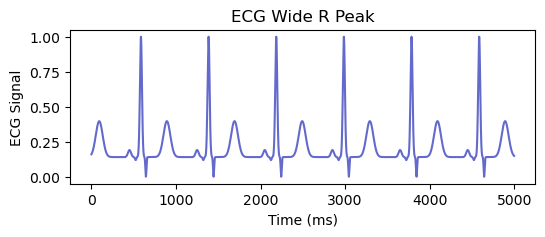

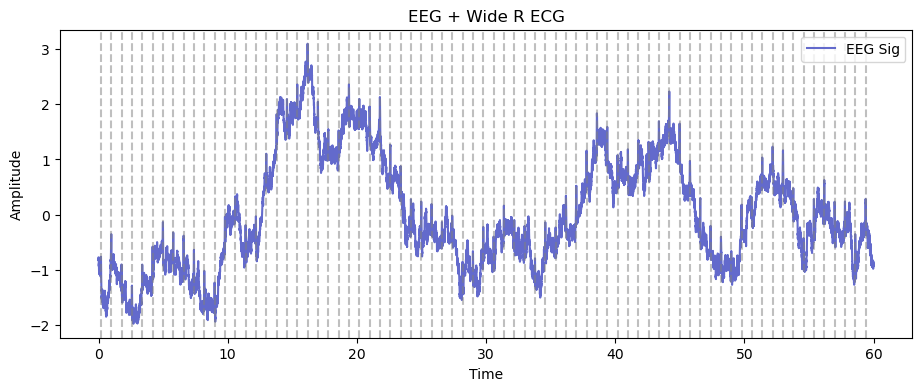

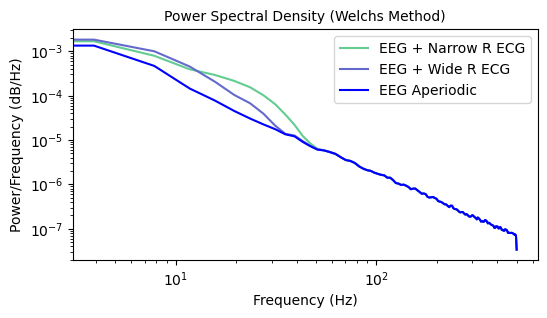

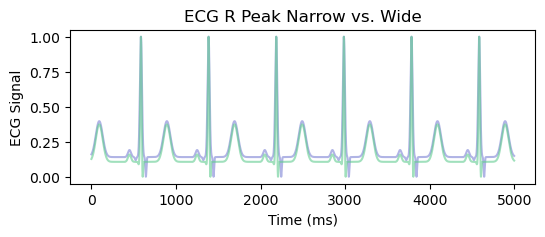

In [55]:
# Wide 
# Define parameters for the wide peak
peak_index = 2
desired_width_wide = 12

# Extract the parameters for the specified peak
peak_params = gaussian_params[peak_index*3 : (peak_index+1)*3]
center, height, width = peak_params

# Determine the width change
width_change = desired_width_wide - width

# Determine the adjustment factor for neighboring peaks
adjustment_factor = width_change / width

# Update the center values of neighboring peaks (Q and S)
if peak_index > 0:
    gaussian_params[(peak_index-1)*3] -= 5
if peak_index < (len(gaussian_params) // 3) - 1:
    gaussian_params[(peak_index+1)*3] += 5

# Update the width of the specified peak
gaussian_params[peak_index*3 + 2] = desired_width_wide
wide_gaussian_params = gaussian_params

# Print the updated parameters and the new width
print("\nUpdated parameters:")
print(gaussian_params)
print("\nNew width of the R peak:", desired_width_wide)

#generate sig
rhythmic_process_wide, rhythmic_sig_wide = generate_rhythmic_signal(time_range = time_range, xs=xs, min_spike_interval=min_spike_interval, gaussian_params=narr_gaussian_params)

## Normalize ECG signal 
wide_sig_norm = (rhythmic_sig_wide - np.mean(rhythmic_sig_wide)) / np.std(rhythmic_sig_wide)
# Min-Max scaling; putting all ecg cycles on 0-1 scale
ecg_min_max_scaled_wide = (wide_sig_norm - np.min(wide_sig_norm)) / (np.max(wide_sig_norm) - np.min(wide_sig_norm))

# Plot the resulting ECG signal
plt.figure(figsize=(6, 2))
plt.plot(ecg_min_max_scaled_wide[CROP_MIN:CROP_MAX], color = "#636ACC", label = 'Wide R Peak')
plt.xlabel('Time (ms)')
plt.ylabel('ECG Signal')
plt.title('ECG Wide R Peak')
plt.show()

########################

########################
#Plot EEG and ECG together
# Find the maximum amplitude of br_noise_norm
max_amplitude_br_noise = np.max(np.abs(br_noise))

# Define the scaling factor to make poisson_sig_norm 10% of max_amplitude_br_noise
scaling_factor = (0.2 * max_amplitude_br_noise) / np.max(narr_sig_norm)

# Scale down the poisson_sig_norm
#The scaling_factor is calculated to scale down the poisson_sig_norm such that its maximum value becomes 10% of the maximum amplitude of br_noise_norm.
scaled_wide_sig = wide_sig_norm * scaling_factor

# # Multiply the signals together
# Superimpose the signals by adding them together
resulting_signal_wide = br_noise + scaled_wide_sig

# Find the indices of maxima in poisson_sig_norm 
max_indices = np.where(wide_sig_norm == np.max(wide_sig_norm))[0]

plt.figure(figsize=(11, 4))
#color: #636ACC
plt.plot(times, resulting_signal_wide, color='#636ACC', label='EEG Sig')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('EEG + Wide R ECG')
plt.legend()
for index in max_indices:
    plt.axvline(x=times[index], color='grey', linestyle='--', alpha = 0.5)
plt.show()


########################

########################
#PSD Wlech
# Calculate the Power Spectral Density (PSD) using Welch's method
f_wide, Pxx_wide = welch(resulting_signal_wide, fs=1000, nperseg=nperseg, noverlap=noverlap)

plt.figure(figsize=(6, 3))
# Plot the Power Spectral Density (PSD) in log-log space for both signals
plt.loglog(f_narr, Pxx_narr, label='EEG + Narrow R ECG', color = "#63cc91")
plt.loglog(f_wide, Pxx_wide, label='EEG + Wide R ECG', color = "#636ACC")
plt.loglog(f_br, Pxx_br, label='EEG Aperiodic', color = 'blue')
plt.title('Power Spectral Density (Welchs Method)', fontsize=10)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.show()


########################

########################
# Plot the resulting ECG signal
plt.figure(figsize=(6, 2))
plt.plot(ecg_min_max_scaled_wide[CROP_MIN:CROP_MAX], color = "#636ACC", label = 'Wide R Peak', alpha = 0.5)
plt.plot(ecg_min_max_scaled_narr[CROP_MIN:CROP_MAX], color = "#63cc91", label = 'Narrow R Peak', alpha = 0.6)
plt.xlabel('Time (ms)')
plt.ylabel('ECG Signal')
plt.title('ECG R Peak Narrow vs. Wide')
plt.show()




## Sensitivity Analysis 
Want to test if length of sample significantly alters FOOOF fits for 2-40 Hz 


In [ ]:
%matplotlib inline

#######KEY ATTRIBUTES ##########
#FS = sampling rate; The sampling frequency of `ecg_signal` (in Hz, i.e., samples/second).
FS = 1000

### Parameters
CROP_MIN = 10000
CROP_MAX = 15000
WINDOW_LENGTH = 5000

#Simple Welch Input
fs = 1000  # Sampling frequency (Hz)
nperseg = 512  # Example window length
noverlap = 256  # Example overlap (equv to 50%)

# Set the time range (0 to ____ ms)

In [ ]:
# Set the time range (0 to ____ ms)
long_time_range = np.arange(0, 60000)
min_spike_interval = 800
xs = np.arange(0, 700)
seed = 5
rate_parameter = 0.005 

#Gaussian Params 
gaussian_params = np.array([ 5.00000000e+01,  1.86660441e+03,  1.79841848e+01,  
                                 1.51461650e+02,  -8.16814518e+02,  7.71994180e+00,  
                                 1.85637028e+02,  3.18867419e+04, 1.13499461e+01,  
                                 2.15193654e+02, -5.20392350e+03,  6.11511696e+00,
                                 4.92442009e+02,  9.51070840e+03,  4.08261600e+01])
